# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '13'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="graupel"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                     (cell: 2684736)
Dimensions without coordinates: cell
Data variables: (12/145)
    time                        (cell) float32 ...
    q_cloud                     (cell) float32 ...
    n_cloud                     (cell) float32 ...
    q_rain                      (cell) float32 ...
    n_rain                      (cell) float32 ...
    q_ice                       (cell) float32 ...
    ...                          ...
    frze_graupel_rain_mass      (cell) float32 ...
    frze_graupel_rain_rmass     (cell) float32 ...
    frze_graupel_rain_rvol      (cell) float32 ...
    frze_graupel_rain_liq       (cell) float32 ...
    rime_graupel_rain_num       (cell) float32 ...
    rime_graupel_rain_mass      (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Di 31 Mai 2022 08:35:12 CEST
    nfiles:   18051


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_graupel.values
    n_s  = xr.open_dataset(fname).n_graupel.values
    r_s  = xr.open_dataset(fname).rime_graupel.values
    v_s  = xr.open_dataset(fname).rvol_graupel.values
    liq_s = xr.open_dataset(fname).liq_graupel.values
    # sedimentation velocities
    vel_num  = xr.open_dataset(fname).graupel_vel_num.values
    vel_liq  = xr.open_dataset(fname).graupel_vel_liq.values
    vel_mass = xr.open_dataset(fname).graupel_vel_mass.values
    vel_rime = xr.open_dataset(fname).graupel_vel_rime.values
    vel_liq  = np.where(vel_liq < vel_mass,vel_mass,vel_liq)  
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # use liquid water fraction (no log transform for this)
    liq_s = np.where(q_s>q_min,liq_s/q_s,np.nan)  
    liq_s = np.where(liq_s<0,np.nan,liq_s)  
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    vel_num  = np.log(vel_num,  where=vel_num>p_min,  out=np.nan*vel_num)    
    vel_mass = np.log(vel_mass, where=vel_mass>p_min, out=np.nan*vel_mass)
    vel_rime = np.log(vel_rime, where=vel_rime>p_min, out=np.nan*vel_rime)
    vel_liq  = np.log(vel_liq,  where=vel_liq>p_min,  out=np.nan*vel_liq)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, liq_s, rho, vel_num, vel_mass, vel_rime, vel_liq ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'liq_s', 'rho', 'vel_num', 'vel_mass', 'vel_rime', 'vel_liq' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  2.662995e+06  2.662995e+06  2.662995e+06  2.662995e+06  2.662995e+06   
mean  -7.562223e+00  3.985835e+00 -7.846392e+00 -1.446400e+01  1.466284e-01   
std    3.432529e+00  4.067019e+00  3.645331e+00  3.627770e+00  2.631664e-01   
min   -2.252508e+01 -1.449861e+01 -2.257248e+01 -2.763092e+01  0.000000e+00   
25%   -8.995874e+00  2.335972e+00 -9.320646e+00 -1.602533e+01  0.000000e+00   
50%   -6.623479e+00  4.870914e+00 -6.781299e+00 -1.347320e+01  1.038912e-06   
75%   -5.021421e+00  6.653172e+00 -5.162555e+00 -1.174646e+01  1.633945e-01   
max   -3.005338e+00  1.231268e+01 -3.134305e+00 -8.395064e+00  1.000000e+00   

                rho       vel_num      vel_mass      vel_rime       vel_liq  
count  2.662995e+06  2.662995e+06  2.662995e+06  2.662995e+06  2.662995e+06  
mean   9.462730e-01  1.603130e+00  1.970531e+00  1.971606e+00  1.986529e+00  
std    1.878752e-01  7.600186e-01  7.272331e-01  7.271259e-01  7.314850e-01  
min    4.880000e-01 -7.614393e+00 -1.583216e+01 -1.058589e+01 -1.583216e+01  
25%    7.880000e-01  1.158138e+00  1.589439e+00  1.591274e+00  1.606233e+00  
50%    9.620000e-01  1.788253e+00  2.029857e+00  2.024985e+00  2.047564e+00  
75%    1.110000e+00  2.179965e+00  2.369309e+00  2.373975e+00  2.374440e+00  
max    1.289000e+00  5.294811e+00  5.422745e+00  5.375278e+00  5.423186e+00

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s  liq_s    rho   vel_num  \
0 -19.126671 -1.673976 -19.174299 -24.436930    0.0  0.962 -0.094091   
1 -19.101721 -1.673976 -19.148792 -24.422075    0.0  0.963 -0.081970   
2 -19.077400 -1.673976 -19.123919 -24.407635    0.0  0.965 -0.070315   
3 -19.046076 -1.673976 -19.091715 -24.386829    0.0  0.967 -0.055513   
5 -19.019609 -1.673976 -19.065189 -24.376547    0.0  0.970 -0.042490   

   vel_mass  vel_rime   vel_liq  
0 -0.094091 -0.094091 -0.094091  
1 -0.081970 -0.081970 -0.081970  
2 -0.070315 -0.070315 -0.070315  
3 -0.055513 -0.055513 -0.055513  
5 -0.042490 -0.042490 -0.042490

In [11]:
dataset_train.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.863113e+06  1.863113e+06  1.863113e+06  1.863113e+06  1.863113e+06   
mean  -7.561365e+00  3.988569e+00 -7.845927e+00 -1.446356e+01  1.467679e-01   
std    3.430836e+00  4.065057e+00  3.643743e+00  3.626297e+00  2.633941e-01   
min   -2.252508e+01 -1.449861e+01 -2.257248e+01 -2.763082e+01  0.000000e+00   
25%   -8.993054e+00  2.338338e+00 -9.319029e+00 -1.602369e+01  0.000000e+00   
50%   -6.623705e+00  4.871757e+00 -6.781651e+00 -1.347426e+01  1.006654e-06   
75%   -5.022703e+00  6.654745e+00 -5.163699e+00 -1.174760e+01  1.635433e-01   
max   -3.005338e+00  1.231268e+01 -3.134305e+00 -8.395064e+00  1.000000e+00   

                rho       vel_num      vel_mass      vel_rime       vel_liq  
count  1.863113e+06  1.863113e+06  1.863113e+06  1.863113e+06  1.863113e+06  
mean   9.461336e-01  1.603015e+00  1.970392e+00  1.971500e+00  1.986366e+00  
std    1.879278e-01  7.604043e-01  7.274259e-01  7.272657e-01  7.317054e-01  
min    4.880000e-01 -7.614393e+00 -1.583216e+01 -1.058589e+01 -1.583216e+01  
25%    7.880000e-01  1.157824e+00  1.589235e+00  1.591070e+00  1.605831e+00  
50%    9.620000e-01  1.788421e+00  2.029989e+00  2.025249e+00  2.047564e+00  
75%    1.110000e+00  2.180079e+00  2.368373e+00  2.373975e+00  2.373975e+00  
max    1.289000e+00  5.294811e+00  5.377129e+00  5.372961e+00  5.380818e+00

In [12]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  399264.000000  399264.000000  399264.000000  399264.000000   
mean       -7.559337       3.976909      -7.843784     -14.461632   
std         3.435513       4.073893       3.648934       3.631864   
min       -22.499409     -14.498609     -22.546825     -27.629921   
25%        -9.001153       2.325105      -9.319458     -16.026245   
50%        -6.619423       4.865918      -6.779934     -13.470149   
75%        -5.012770       6.648816      -5.153217     -11.740328   
max        -3.078701      12.043260      -3.191236      -8.584991   

               liq_s            rho        vel_num       vel_mass  \
count  399264.000000  399264.000000  399264.000000  399264.000000   
mean        0.147002       0.946800       1.604403       1.971751   
std         0.263081       0.187756       0.759493       0.727602   
min         0.000000       0.488000      -5.259674     -15.829165   
25%         0.000000       0.789000       1.159707       1.590867   
50%         0.000001       0.963000       1.789423       2.030251   
75%         0.165395       1.111000       2.180644       2.369309   
max         0.999947       1.288000       4.439234       5.379436   

            vel_rime        vel_liq  
count  399264.000000  399264.000000  
mean        1.972797       1.987868  
std         0.727497       0.731773  
min       -10.085249     -15.829165  
25%         1.592699       1.608437  
50%         2.025645       2.047822  
75%         2.374906       2.374906  
max         4.905275       5.380818

In [13]:
dataset_val.describe()

q_s            n_s            r_s            v_s  \
count  400618.000000  400618.000000  400618.000000  400618.000000   
mean       -7.569059       3.982013      -7.851153     -14.468376   
std         3.437424       4.069273       3.649124       3.630541   
min       -22.500944     -14.498609     -22.548313     -27.630920   
25%        -9.002432       2.335923      -9.329093     -16.031620   
50%        -6.626192       4.871986      -6.779538     -13.471035   
75%        -5.025260       6.650159      -5.166311     -11.748775   
max        -3.190167      12.197687      -3.234421      -8.579600   

               liq_s            rho        vel_num       vel_mass  \
count  400618.000000  400618.000000  400618.000000  400618.000000   
mean        0.145607       0.946399       1.602396       1.969966   
std         0.262188       0.187748       0.758748       0.725968   
min         0.000000       0.488000      -4.134542      -4.134542   
25%         0.000000       0.789000       1.158138       1.588827   
50%         0.000001       0.962000       1.786579       2.028674   
75%         0.160636       1.110000       2.178495       2.368373   
max         0.999725       1.288000       4.244200       5.422745   

            vel_rime        vel_liq  
count  400618.000000  400618.000000  
mean        1.970912       1.985958  
std         0.726105       0.730172  
min        -4.134542      -4.134542  
25%         1.590663       1.606233  
50%         2.023532       2.046789  
75%         2.373975       2.373975  
max         5.375278       5.423186

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['vel_mass'] < -2 ].index  # remove some outliers
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06   
mean  -7.539380e+00  4.006778e+00 -7.824174e+00 -1.444252e+01  1.468825e-01   
std    3.391606e+00  4.041340e+00  3.608109e+00  3.592955e+00  2.635359e-01   
min   -1.999988e+01 -1.449861e+01 -2.211200e+01 -2.762992e+01  0.000000e+00   
25%   -8.978594e+00  2.360288e+00 -9.300123e+00 -1.600584e+01  0.000000e+00   
50%   -6.618861e+00  4.877485e+00 -6.777429e+00 -1.347008e+01  1.018660e-06   
75%   -5.019607e+00  6.657745e+00 -5.160854e+00 -1.174472e+01  1.637422e-01   
max   -3.005338e+00  1.231268e+01 -3.134305e+00 -8.395064e+00  1.000000e+00   

                rho       vel_num      vel_mass      vel_rime       vel_liq  
count  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06  
mean   9.459466e-01  1.604298e+00  1.972233e+00  1.973332e+00  1.988213e+00  
std    1.879703e-01  7.591004e-01  7.248964e-01  7.250063e-01  7.291765e-01  
min    4.880000e-01 -2.568375e+00 -1.982678e+00 -2.175952e+00 -1.944212e+00  
25%    7.880000e-01  1.159394e+00  1.590459e+00  1.592495e+00  1.607035e+00  
50%    9.610000e-01  1.789256e+00  2.031039e+00  2.026436e+00  2.048725e+00  
75%    1.110000e+00  2.180530e+00  2.369309e+00  2.374906e+00  2.374906e+00  
max    1.289000e+00  5.294811e+00  5.377129e+00  5.372961e+00  5.380818e+00

In [17]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  398612.000000  398612.000000  398612.000000  398612.000000   
mean       -7.538117       3.994634      -7.822795     -14.441308   
std         3.397816       4.050905       3.614676       3.599739   
min       -19.999395     -14.498609     -21.499620     -27.629921   
25%        -8.984241       2.346195      -9.303772     -16.008546   
50%        -6.614340       4.871373      -6.774186     -13.465452   
75%        -5.011058       6.651895      -5.151536     -11.738560   
max        -3.078701      12.043260      -3.191236      -8.584991   

               liq_s            rho        vel_num       vel_mass  \
count  398612.000000  398612.000000  398612.000000  398612.000000   
mean        0.147106       0.946611       1.605555       1.973432   
std         0.263219       0.187795       0.758403       0.725342   
min         0.000000       0.488000      -2.238672      -1.809720   
25%         0.000000       0.789000       1.160961       1.592088   
50%         0.000001       0.962000       1.790091       2.031432   
75%         0.165600       1.111000       2.181095       2.370244   
max         0.999947       1.288000       4.439234       5.379436   

            vel_rime        vel_liq  
count  398612.000000  398612.000000  
mean        1.974475       1.989552  
std         0.725521       0.729508  
min        -1.809109      -1.809720  
25%         1.593715       1.609638  
50%         2.026700       2.048853  
75%         2.374906       2.375836  
max         4.905275       5.380818

### Pairplot

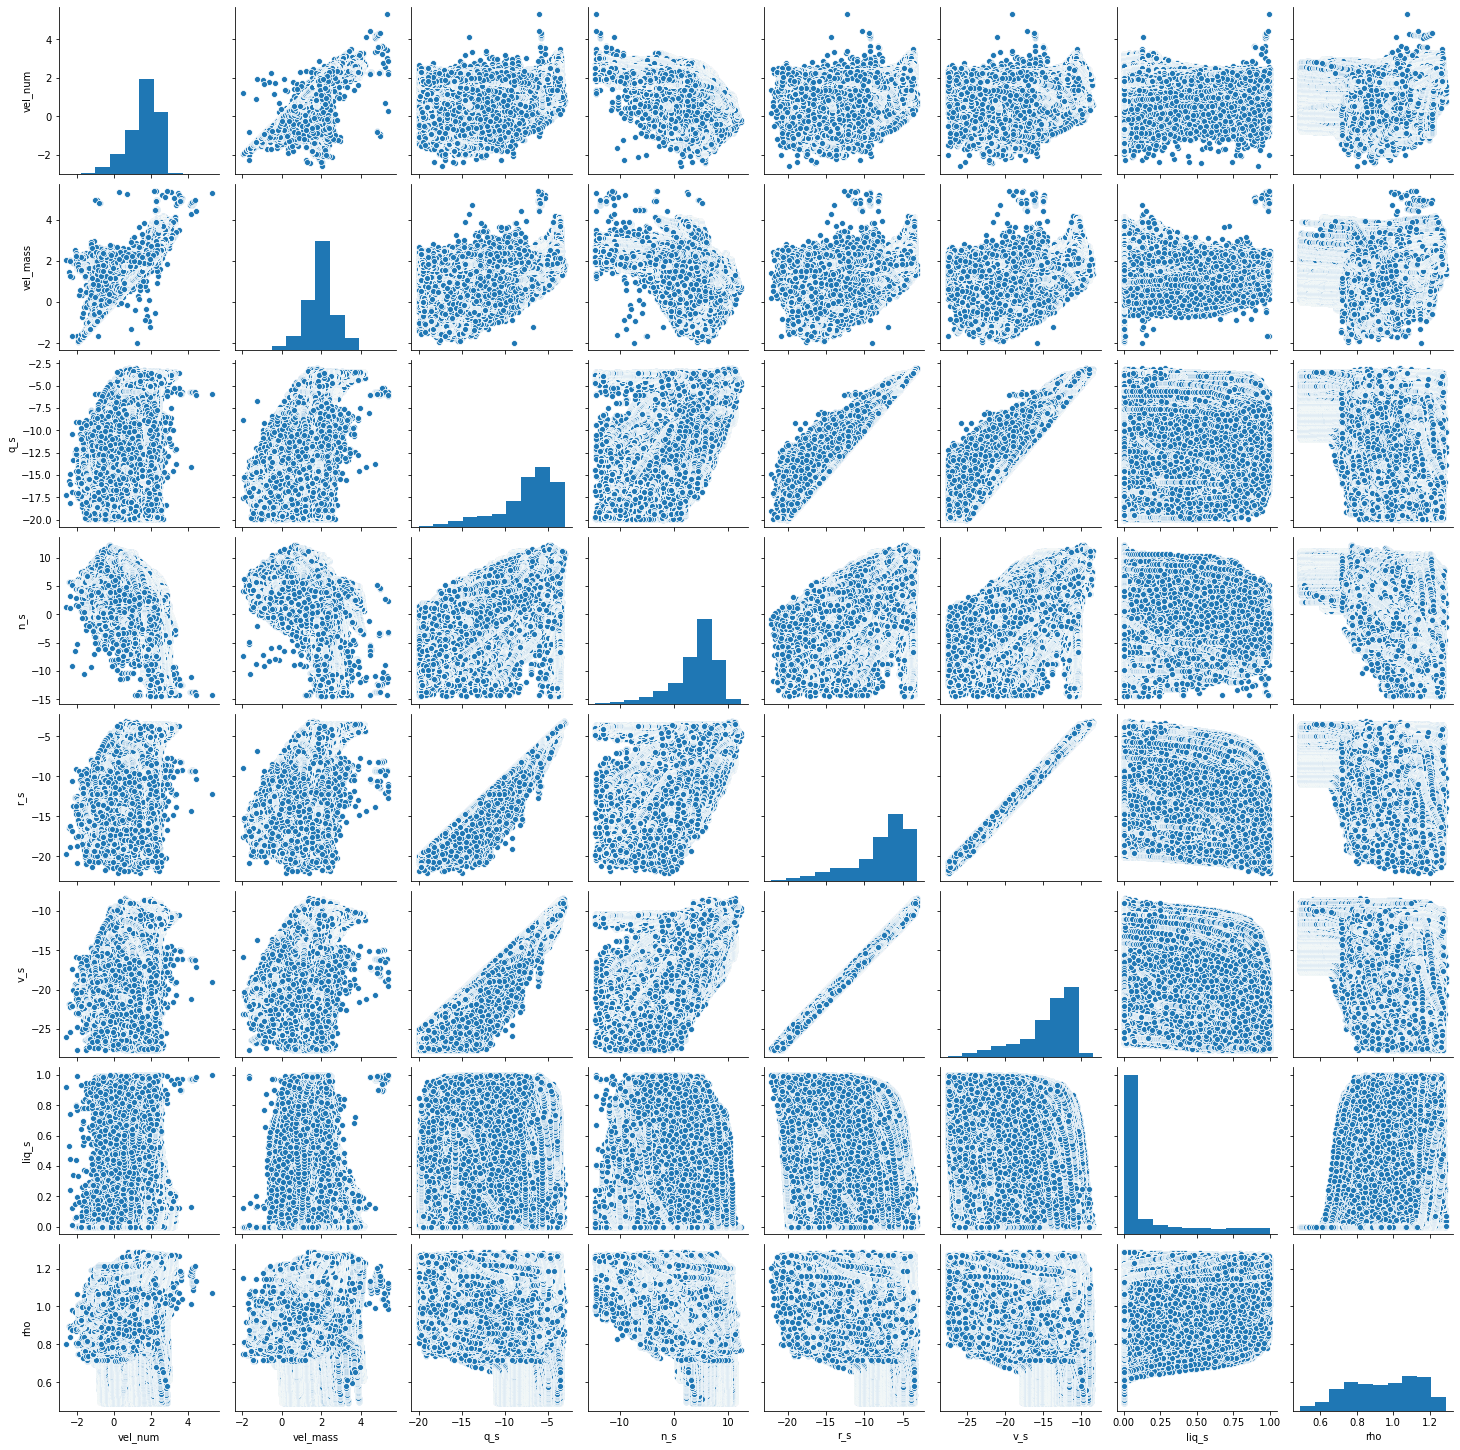

In [18]:
sns.pairplot(dataset_train[["vel_num","vel_mass","q_s","n_s","r_s","v_s","liq_s","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['liq_s','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['liq_s'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['liq_s','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['liq_s'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['liq_s','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['liq_s'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("vel_num")
train_stats1.pop("vel_mass")
train_stats1.pop("vel_rime")
train_stats1.pop("vel_liq")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  1859964.0  -7.539380  3.391606 -19.999880  -8.978594  -6.618861   
n_s  1859964.0   4.006778  4.041340 -14.498609   2.360288   4.877485   
r_s  1859964.0  -7.824174  3.608109 -22.112003  -9.300123  -6.777429   
v_s  1859964.0 -14.442521  3.592955 -27.629921 -16.005838 -13.470078   

           75%        max  
q_s  -5.019607  -3.005338  
n_s   6.657745  12.312682  
r_s  -5.160854  -3.134305  
v_s -11.744719  -8.395064

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("vel_num")
train_stats2.pop("vel_mass")
train_stats2.pop("vel_rime")
train_stats2.pop("vel_liq")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
q_s  1859964.0  -7.539380  3.391606 -19.999880  -8.978594  -6.618861   
n_s  1859964.0   4.006778  4.041340 -14.498609   2.360288   4.877485   
r_s  1859964.0  -7.824174  3.608109 -22.112003  -9.300123  -6.777429   
v_s  1859964.0 -14.442521  3.592955 -27.629921 -16.005838 -13.470078   
rho  1859964.0   0.945947  0.187970   0.488000   0.788000   0.961000   

           75%        max  
q_s  -5.019607  -3.005338  
n_s   6.657745  12.312682  
r_s  -5.160854  -3.134305  
v_s -11.744719  -8.395064  
rho   1.110000   1.289000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("vel_num")
train_stats3.pop("vel_mass")
train_stats3.pop("vel_rime")
train_stats3.pop("vel_liq")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%  \
q_s    1859964.0  -7.539380  3.391606 -19.999880  -8.978594  -6.618861   
n_s    1859964.0   4.006778  4.041340 -14.498609   2.360288   4.877485   
r_s    1859964.0  -7.824174  3.608109 -22.112003  -9.300123  -6.777429   
v_s    1859964.0 -14.442521  3.592955 -27.629921 -16.005838 -13.470078   
liq_s  1859964.0   0.146883  0.263536   0.000000   0.000000   0.000001   
rho    1859964.0   0.945947  0.187970   0.488000   0.788000   0.961000   

             75%        max  
q_s    -5.019607  -3.005338  
n_s     6.657745  12.312682  
r_s    -5.160854  -3.134305  
v_s   -11.744719  -8.395064  
liq_s   0.163742   1.000000  
rho     1.110000   1.289000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['vel_num','vel_mass','vel_rime','vel_liq']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

vel_num      vel_mass      vel_rime       vel_liq
count  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06
mean   1.604298e+00  1.972233e+00  1.973332e+00  1.988213e+00
std    7.591004e-01  7.248964e-01  7.250063e-01  7.291765e-01
min   -2.568375e+00 -1.982678e+00 -2.175952e+00 -1.944212e+00
25%    1.159394e+00  1.590459e+00  1.592495e+00  1.607035e+00
50%    1.789256e+00  2.031039e+00  2.026436e+00  2.048725e+00
75%    2.180530e+00  2.369309e+00  2.374906e+00  2.374906e+00
max    5.294811e+00  5.377129e+00  5.372961e+00  5.380818e+00

In [32]:
train_dataset1.describe()

q_s           n_s           r_s           v_s
count  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06
mean  -7.539380e+00  4.006778e+00 -7.824174e+00 -1.444252e+01
std    3.391606e+00  4.041340e+00  3.608109e+00  3.592955e+00
min   -1.999988e+01 -1.449861e+01 -2.211200e+01 -2.762992e+01
25%   -8.978594e+00  2.360288e+00 -9.300123e+00 -1.600584e+01
50%   -6.618861e+00  4.877485e+00 -6.777429e+00 -1.347008e+01
75%   -5.019607e+00  6.657745e+00 -5.160854e+00 -1.174472e+01
max   -3.005338e+00  1.231268e+01 -3.134305e+00 -8.395064e+00

In [33]:
train_dataset2.describe()

q_s           n_s           r_s           v_s           rho
count  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06
mean  -7.539380e+00  4.006778e+00 -7.824174e+00 -1.444252e+01  9.459466e-01
std    3.391606e+00  4.041340e+00  3.608109e+00  3.592955e+00  1.879703e-01
min   -1.999988e+01 -1.449861e+01 -2.211200e+01 -2.762992e+01  4.880000e-01
25%   -8.978594e+00  2.360288e+00 -9.300123e+00 -1.600584e+01  7.880000e-01
50%   -6.618861e+00  4.877485e+00 -6.777429e+00 -1.347008e+01  9.610000e-01
75%   -5.019607e+00  6.657745e+00 -5.160854e+00 -1.174472e+01  1.110000e+00
max   -3.005338e+00  1.231268e+01 -3.134305e+00 -8.395064e+00  1.289000e+00

In [34]:
train_dataset3.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06  1.859964e+06   
mean  -7.539380e+00  4.006778e+00 -7.824174e+00 -1.444252e+01  1.468825e-01   
std    3.391606e+00  4.041340e+00  3.608109e+00  3.592955e+00  2.635359e-01   
min   -1.999988e+01 -1.449861e+01 -2.211200e+01 -2.762992e+01  0.000000e+00   
25%   -8.978594e+00  2.360288e+00 -9.300123e+00 -1.600584e+01  0.000000e+00   
50%   -6.618861e+00  4.877485e+00 -6.777429e+00 -1.347008e+01  1.018660e-06   
75%   -5.019607e+00  6.657745e+00 -5.160854e+00 -1.174472e+01  1.637422e-01   
max   -3.005338e+00  1.231268e+01 -3.134305e+00 -8.395064e+00  1.000000e+00   

                rho  
count  1.859964e+06  
mean   9.459466e-01  
std    1.879703e-01  
min    4.880000e-01  
25%    7.880000e-01  
50%    9.610000e-01  
75%    1.110000e+00  
max    1.289000e+00

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  1859964.0  2.696358e-07  1.0 -3.673924 -0.424346  0.271411  0.742944   
n_s  1859964.0  2.504017e-07  1.0 -4.579022 -0.407412  0.215450  0.655962   
r_s  1859964.0 -1.252800e-06  1.0 -3.959921 -0.409064  0.290109  0.738148   
v_s  1859964.0 -1.179451e-07  1.0 -3.670349 -0.435106  0.270653  0.750859   

          max  
q_s  1.336842  
n_s  2.055235  
r_s  1.299813  
v_s  1.683143

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s  1859964.0  2.696358e-07  1.0 -3.673924 -0.424346  0.271411  0.742944   
n_s  1859964.0  2.504017e-07  1.0 -4.579022 -0.407412  0.215450  0.655962   
r_s  1859964.0 -1.252800e-06  1.0 -3.959921 -0.409064  0.290109  0.738148   
v_s  1859964.0 -1.179451e-07  1.0 -3.670349 -0.435106  0.270653  0.750859   
rho  1859964.0  5.806377e-07  1.0 -2.436270 -0.840274  0.080084  0.872762   

          max  
q_s  1.336842  
n_s  2.055235  
r_s  1.299813  
v_s  1.683143  
rho  1.825040

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s    1859964.0  2.696358e-07  1.0 -3.673924 -0.424346  0.271411  0.742944   
n_s    1859964.0  2.504017e-07  1.0 -4.579022 -0.407412  0.215450  0.655962   
r_s    1859964.0 -1.252800e-06  1.0 -3.959921 -0.409064  0.290109  0.738148   
v_s    1859964.0 -1.179451e-07  1.0 -3.670349 -0.435106  0.270653  0.750859   
liq_s  1859964.0 -1.037927e-07  1.0 -0.557353 -0.557353 -0.557349  0.063975   
rho    1859964.0  5.806377e-07  1.0 -2.436270 -0.840274  0.080084  0.872762   

            max  
q_s    1.336842  
n_s    2.055235  
r_s    1.299813  
v_s    1.683143  
liq_s  3.237197  
rho    1.825040

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std       min       25%       50%  \
vel_num   1859964.0  1.604298  0.759100 -2.568375  1.159394  1.789256   
vel_mass  1859964.0  1.972233  0.724896 -1.982678  1.590459  2.031039   
vel_rime  1859964.0  1.973332  0.725006 -2.175952  1.592495  2.026436   
vel_liq   1859964.0  1.988213  0.729176 -1.944212  1.607035  2.048725   

               75%       max  
vel_num   2.180530  5.294811  
vel_mass  2.369309  5.377129  
vel_rime  2.374906  5.372961  
vel_liq   2.374906  5.380818

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 692
Trainable params: 692
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.67223346, -0.67008495,  0.00165248,  0.36173868],
       [-0.67229   , -0.67008734,  0.0016751 ,  0.361777  ],
       [-0.67234516, -0.6700897 ,  0.00169724,  0.36181444],
       [-0.672421  , -0.6700932 ,  0.00172639,  0.36186612],
       [-0.67247045, -0.67009515,  0.00174859,  0.36189836],
       [-0.67249286, -0.67009604,  0.00175864,  0.36191285],
       [-0.67251486, -0.67009693,  0.00176856,  0.3619272 ],
       [-0.67306846, -0.67012405,  0.00196451,  0.36230606],
       [-0.67308927, -0.67012495,  0.00197354,  0.3623196 ],
       [-0.67313695, -0.6701273 ,  0.00199369,  0.36235029]],
      dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [47]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [48]:
activ = "ReLU"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0550,  mae:0.1529,  mse:0.0550,  val_loss:0.0434,  val_mae:0.1360,  val_mse:0.0434,  
.....................................

Text(0, 0.5, 'MAE')

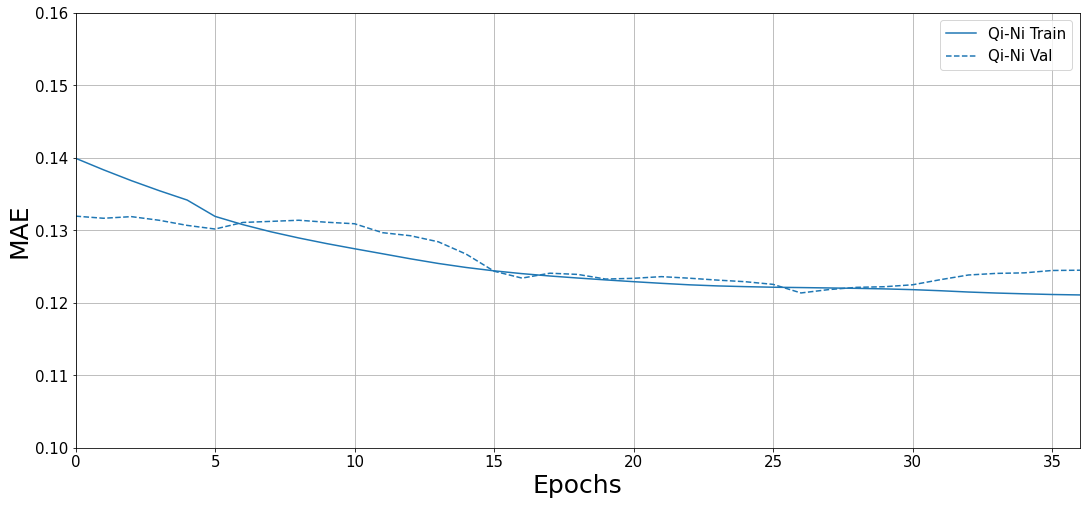

In [49]:
histories['qi-ni'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1,0.16])
plt.ylabel('MAE')

In [50]:
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0399,  mae:0.1174,  mse:0.0399,  val_loss:0.0339,  val_mae:0.1125,  val_mse:0.0339,  
........................................

Text(0, 0.5, 'MAE')

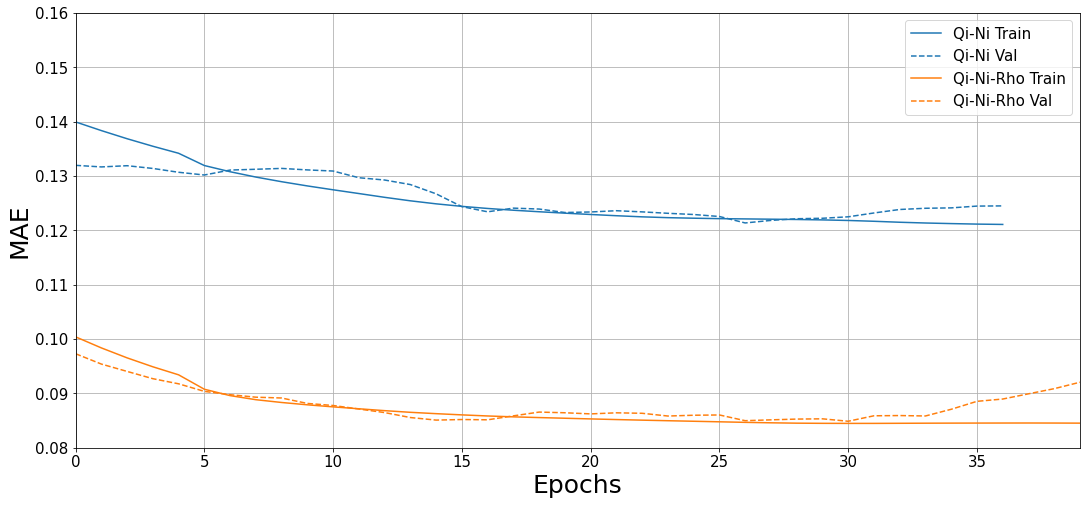

In [51]:
histories['qi-ni-rho'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.08, 0.16])
plt.ylabel('MAE')

In [52]:
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0337,  mae:0.1052,  mse:0.0337,  val_loss:0.0257,  val_mae:0.0924,  val_mse:0.0257,  
..................................

Text(0, 0.5, 'MAE')

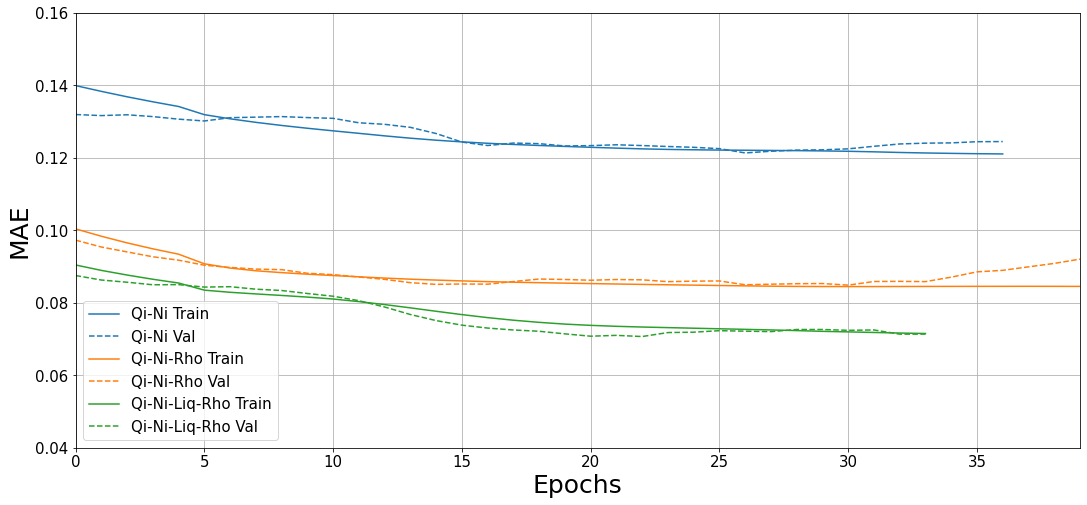

In [53]:
histories['qi-ni-liq-rho'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.16])
plt.ylabel('MAE')

In [54]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0415,  mae:0.1192,  mse:0.0415,  val_loss:0.0312,  val_mae:0.1021,  val_mse:0.0312,  
.................................

Text(0, 0.5, 'MAE')

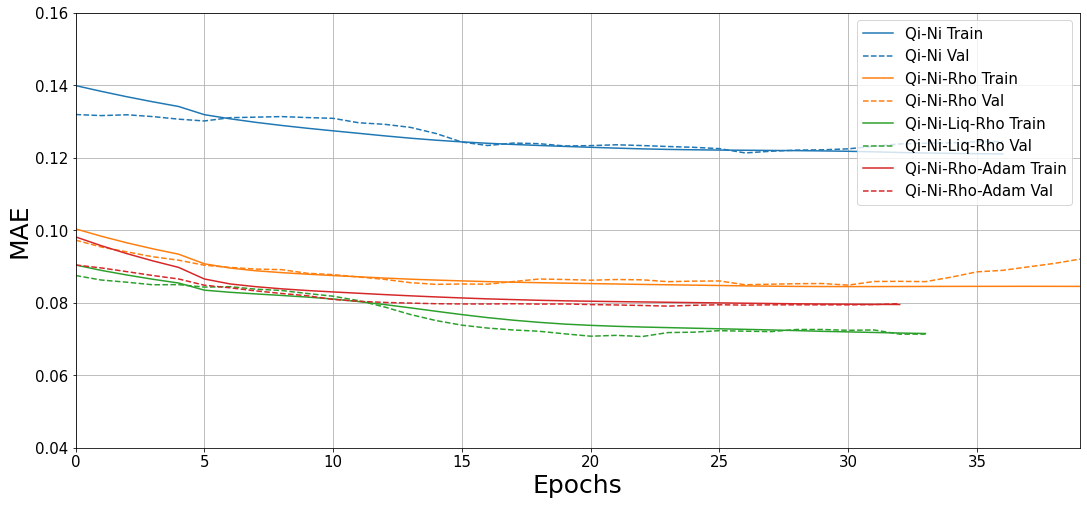

In [55]:
histories['qi-ni-rho-Adam'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.16])
plt.ylabel('MAE')

In [56]:
model5 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0350,  mae:0.1108,  mse:0.0350,  val_loss:0.0271,  val_mae:0.0960,  val_mse:0.0271,  
...........................................................

Text(0, 0.5, 'MAE')

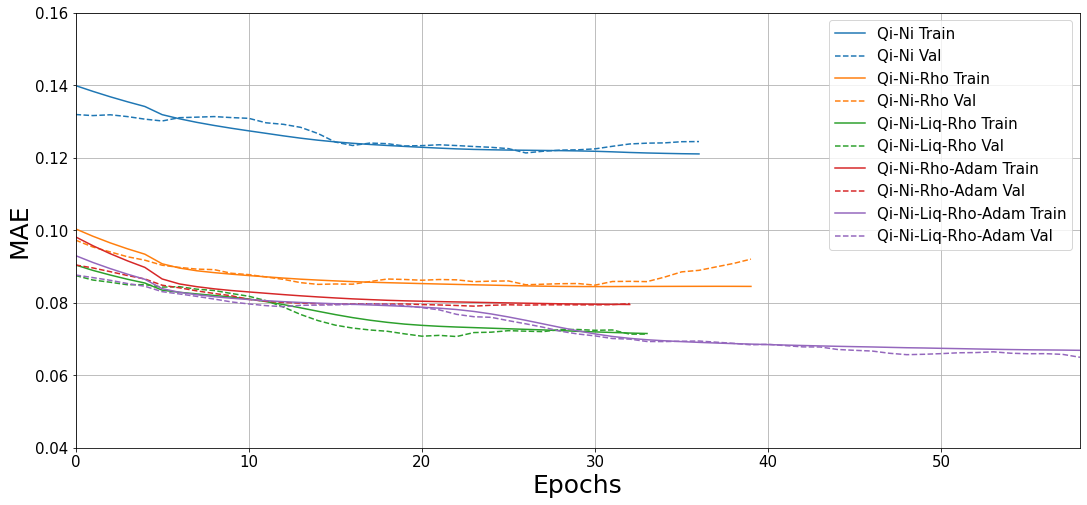

In [57]:
histories['qi-ni-liq-rho-Adam'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.16])
plt.ylabel('MAE')

In [58]:
nsize=32
activ = "ReLU_Adam"
model6 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history6 = model6.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0311,  mae:0.1000,  mse:0.0311,  val_loss:0.0228,  val_mae:0.0868,  val_mse:0.0228,  
.........................................................

Text(0, 0.5, 'MAE')

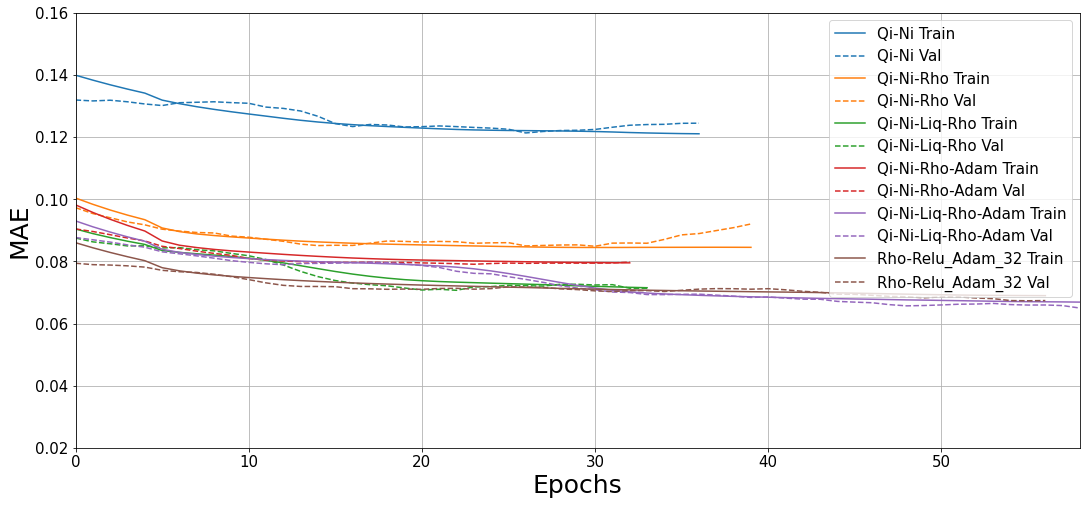

In [59]:
histories['rho-ReLU_Adam_32'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.16])
plt.ylabel('MAE')

In [60]:
activ = "ReLU_Adam"
model7 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history7 = model7.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0284,  mae:0.0957,  mse:0.0284,  val_loss:0.0212,  val_mae:0.0808,  val_mse:0.0212,  
...........................................................................

Text(0, 0.5, 'MAE')

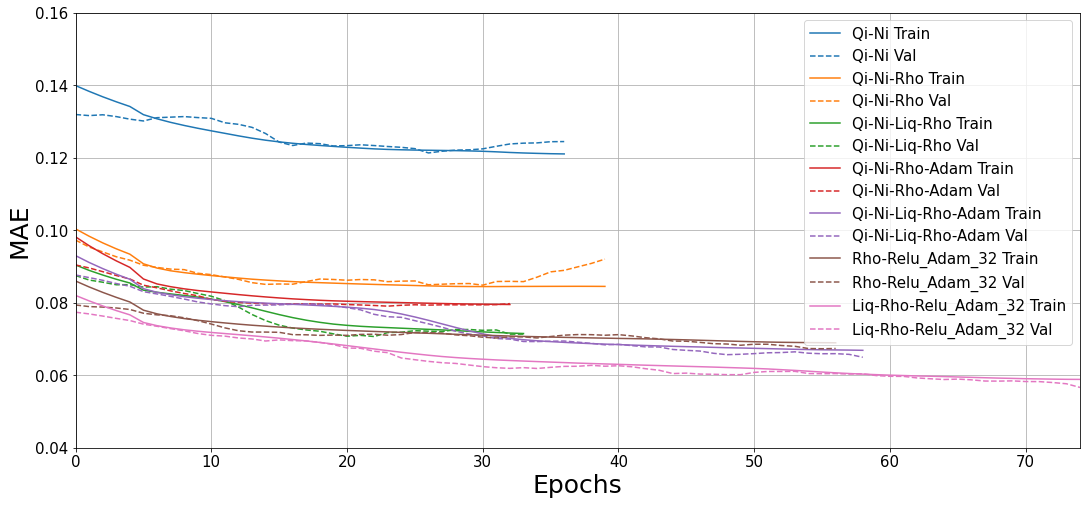

In [61]:
histories['liq-rho-ReLU_Adam_32'] = early_history7

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.16])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

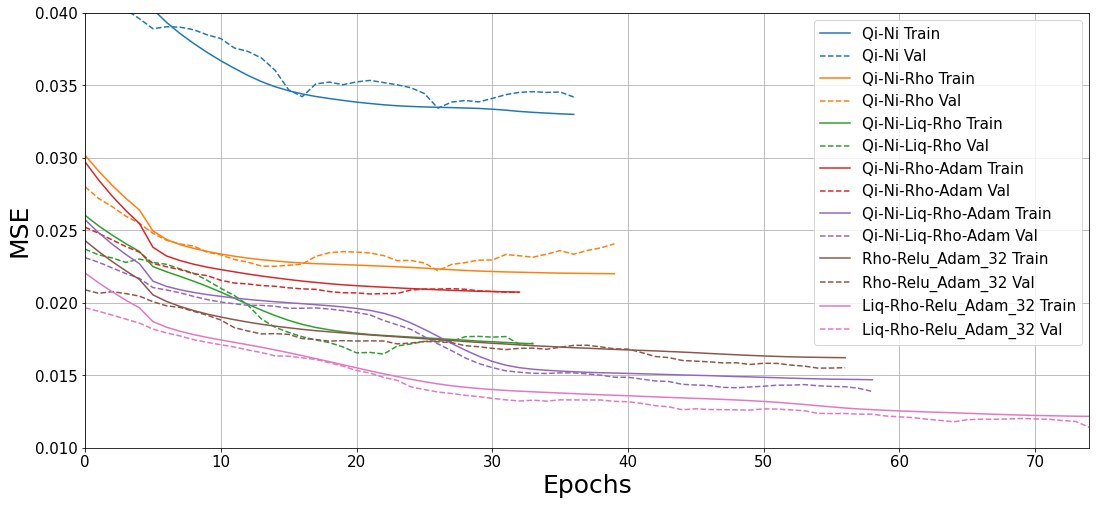

In [62]:

plotter.plot(histories, metric = "mse")
plt.ylim([0.01, 0.04])
plt.ylabel('MSE')

In [63]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

398612/398612 - 9s - loss: 0.0309 - mae: 0.1168 - mse: 0.0309
Testing set for model 1, Mean Abs Error:    0.11676


In [64]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

398612/398612 - 9s - loss: 0.0212 - mae: 0.0833 - mse: 0.0212
Testing set for model 2, Mean Abs Error:              0.08333


In [65]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

398612/398612 - 9s - loss: 0.0153 - mae: 0.0675 - mse: 0.0153
Testing set for model 3, Mean Abs Error:              0.06746


In [66]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

398612/398612 - 9s - loss: 0.0198 - mae: 0.0775 - mse: 0.0198
Testing set for model 4, Mean Abs Error:              0.07746


In [67]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

398612/398612 - 9s - loss: 0.0136 - mae: 0.0628 - mse: 0.0136
Testing set for model 5, Mean Abs Error:              0.06284


In [68]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

398612/398612 - 9s - loss: 0.0152 - mae: 0.0654 - mse: 0.0152
Testing set for model 6, Mean Abs Error:              0.06543


In [69]:
loss7, mae7, mse7 = model7.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 7, Mean Abs Error: {:20.5f}".format(mae7))

398612/398612 - 9s - loss: 0.0113 - mae: 0.0562 - mse: 0.0113
Testing set for model 7, Mean Abs Error:              0.05621


In [70]:
mae = [ mae1, mae2, mae3, mae4, mae5, mae6, mae7 ]
mae

[0.11676463,
 0.08333123,
 0.067459255,
 0.07745966,
 0.06283936,
 0.065429226,
 0.056211304]

In [71]:
mse = [ mse1, mse2, mse3, mse4, mse5, mse6, mse7 ]
mse

[0.030925697,
 0.02117559,
 0.015275465,
 0.019824483,
 0.013558165,
 0.015210207,
 0.011330548]

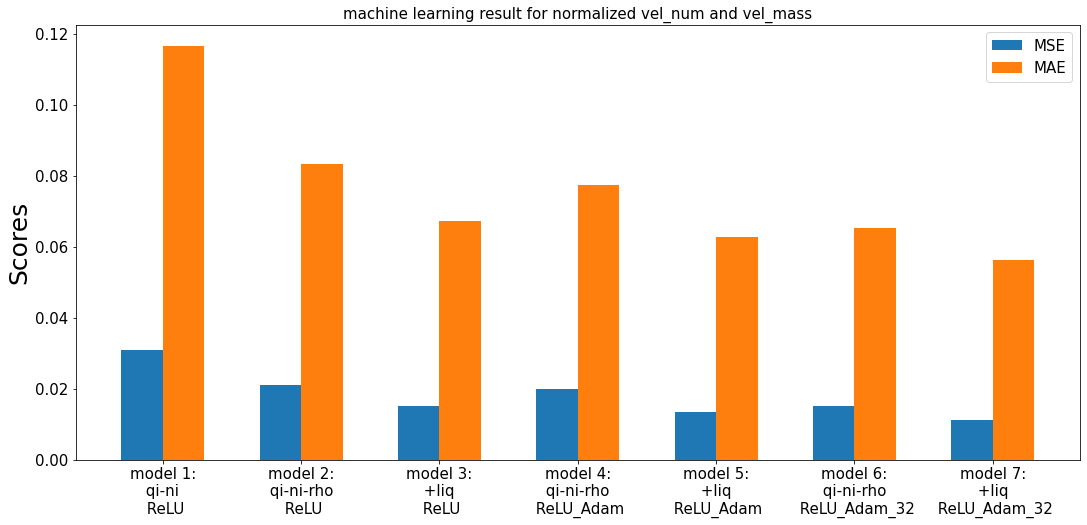

In [72]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1:\n qi-ni \n ReLU',
 'model 2:\n qi-ni-rho \n ReLU',
 'model 3:\n +liq \n ReLU',
 'model 4:\n qi-ni-rho \n ReLU_Adam',
 'model 5:\n +liq \n ReLU_Adam',
 'model 6:\n qi-ni-rho \n ReLU_Adam_32',
 'model 7:\n +liq \n ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [73]:
test_true_num  = np.exp(test_labels.pop('vel_num'))
test_true_mass = np.exp(test_labels.pop('vel_mass'))

In [74]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [75]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["vel_num", "vel_mass","vel_rime","vel_liq"])

In [76]:
p1.describe()

vel_num       vel_mass       vel_rime        vel_liq
count  398612.000000  398612.000000  398612.000000  398612.000000
mean        0.009259      -0.005634      -0.007669       0.005623
std         0.991623       1.004473       1.006870       1.000386
min        -4.439077      -4.959286      -4.975641      -4.931484
25%        -0.571004      -0.530339      -0.534667      -0.512112
50%         0.258936       0.075959       0.074309       0.073195
75%         0.765933       0.548678       0.547759       0.551234
max         3.812421       4.535279       4.488703       4.335904

In [77]:
train_labels_stats

count      mean       std       min       25%       50%  \
vel_num   1859964.0  1.604298  0.759100 -2.568375  1.159394  1.789256   
vel_mass  1859964.0  1.972233  0.724896 -1.982678  1.590459  2.031039   
vel_rime  1859964.0  1.973332  0.725006 -2.175952  1.592495  2.026436   
vel_liq   1859964.0  1.988213  0.729176 -1.944212  1.607035  2.048725   

               75%       max  
vel_num   2.180530  5.294811  
vel_mass  2.369309  5.377129  
vel_rime  2.374906  5.372961  
vel_liq   2.374906  5.380818

In [78]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [79]:
test_predict1.describe()

vel_num       vel_mass       vel_rime        vel_liq
count  398612.000000  398612.000000  398612.000000  398612.000000
mean        6.264216       9.224581       9.232653       9.473389
std         3.578724       7.407755       7.433710       7.676566
min         0.171117       0.197358       0.195140       0.200346
25%         3.224729       4.892932       4.882684       5.026845
50%         6.054830       7.593520       7.592847       7.702807
75%         8.897034      10.697041      10.702327      10.915233
max        89.864998     192.450696     186.358197     172.405900

In [80]:
test_predict1_num  = test_predict1['vel_num']
test_predict1_mass = test_predict1['vel_mass']

In [81]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=["vel_num", "vel_mass","vel_rime","vel_liq"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['vel_num']
test_predict2_mass = test_predict2['vel_mass']

In [82]:

p3 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=["vel_num", "vel_mass","vel_rime","vel_liq"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_num  = test_predict3['vel_num']
test_predict3_mass = test_predict3['vel_mass']

In [83]:

p5 = pd.DataFrame(data=model5.predict(normed_test_data3), columns=["vel_num", "vel_mass","vel_rime","vel_liq"])

test_predict5 = np.exp(backtransform(p5,train_labels_stats))

test_predict5_num  = test_predict5['vel_num']
test_predict5_mass = test_predict5['vel_mass']

### Maybe the ordering of the arrays is different? 

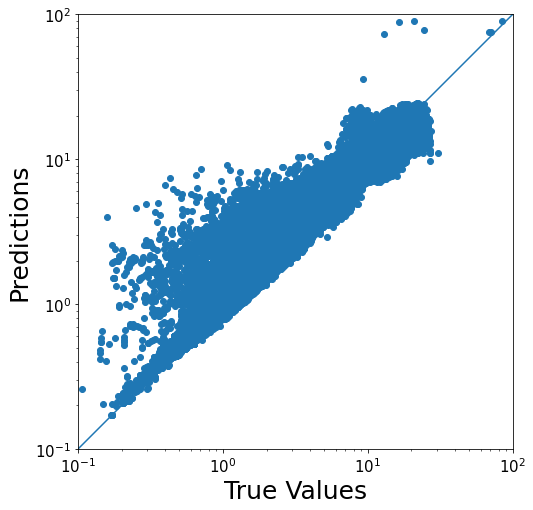

In [84]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-1, 100

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

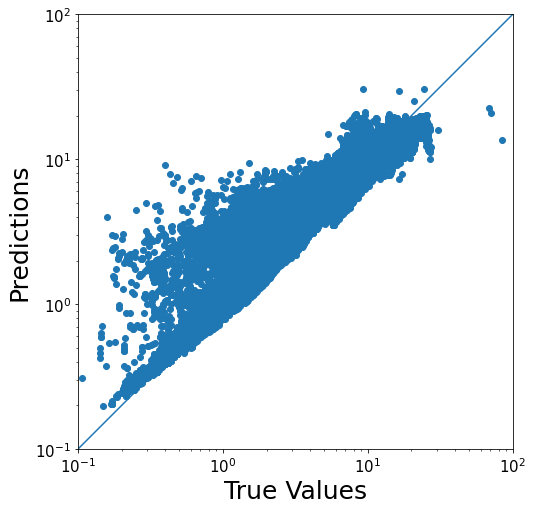

In [85]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

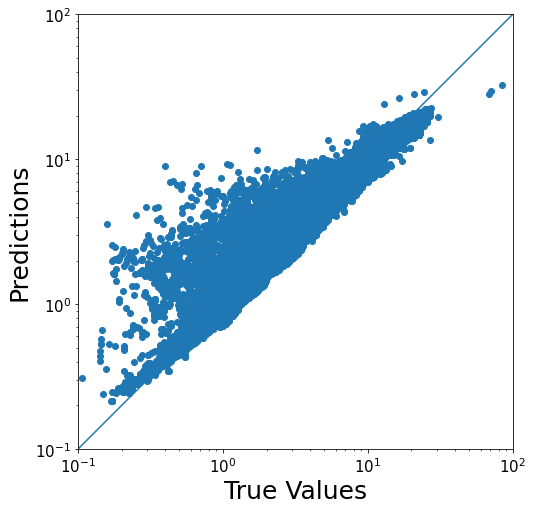

In [86]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict3_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

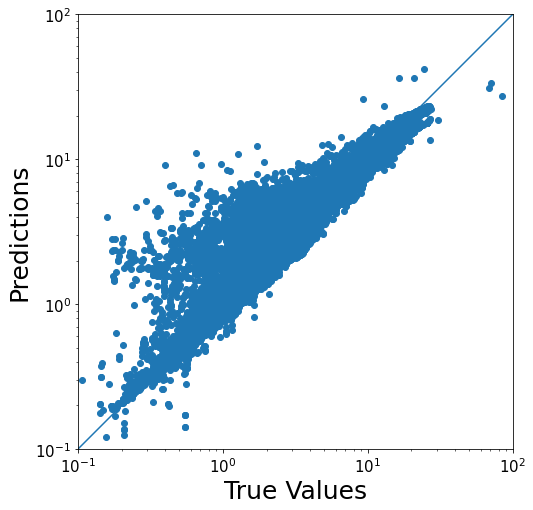

In [87]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict5_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

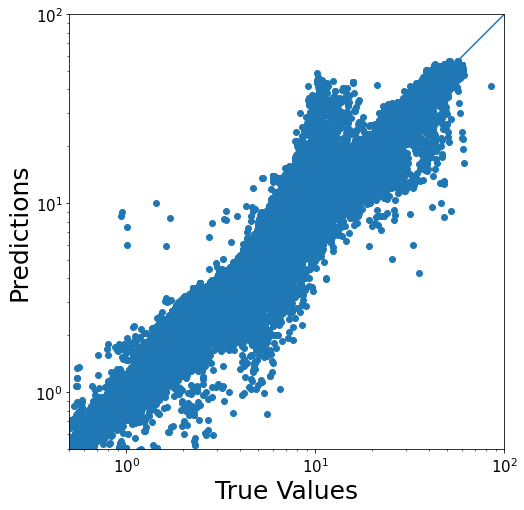

In [88]:
amin, amax = 0.5, 100

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

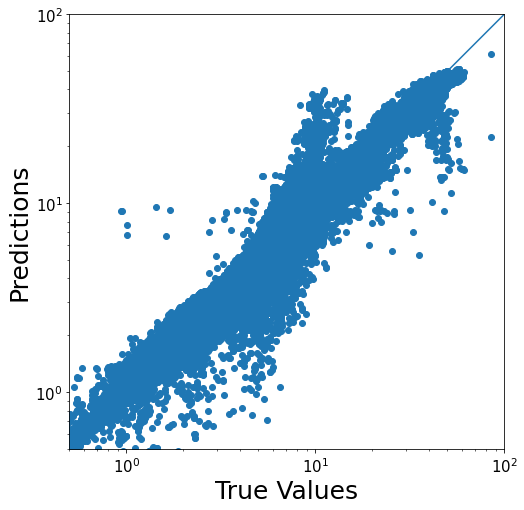

In [89]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

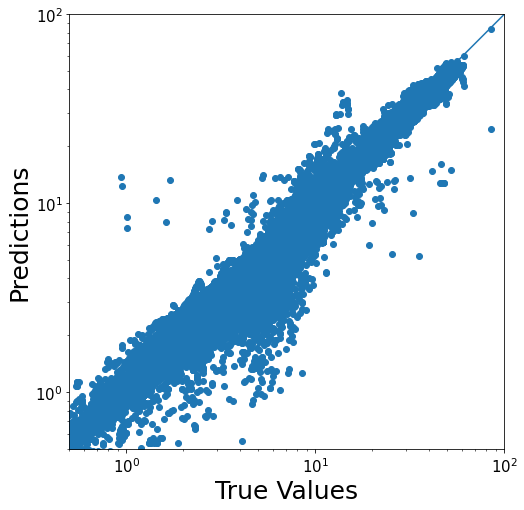

In [90]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict3_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

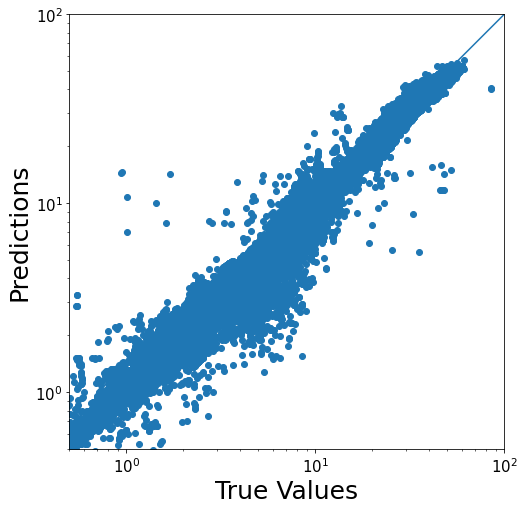

In [91]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict5_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [92]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [93]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [94]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel'
labels   = 'vel_rimesnow_num, vel_rimesnow_mass, vel_graupel_rime, vel_graupel_liq'
filename = 'saved_model_v2/vel_graupel_model1_'+version+'.nc'
logtransform = np.array([True, True, True, True], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/vel_graupel_model1_13.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_graupel_rime, vel_graupel_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 4), Activation: linear


In [95]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel, rho'
logtransform = np.array([True, True, True, True, False], dtype=bool)
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransform,'saved_model_v2/vel_graupel_model2_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,'saved_model_v2/vel_graupel_model4_'+version+'.nc')
save2netcdf(model6,features,labels,train_stats2,train_labels_stats,logtransform,'saved_model_v2/vel_graupel_model6_'+version+'.nc')



Saving model to saved_model_v2/vel_graupel_model2_13.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, rho
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_graupel_rime, vel_graupel_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 4), Activation: linear
Saving model to saved_model_v2/vel_graupel_model4_13.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, rho
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_graupel_rime, vel_graupel_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.pytho

In [96]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac_graupel, rho'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_graupel_model3_'+version+'.nc')
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_graupel_model5_'+version+'.nc')
save2netcdf(model7,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_graupel_model7_'+version+'.nc')

Saving model to saved_model_v2/vel_graupel_model3_13.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac_graupel, rho
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_graupel_rime, vel_graupel_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 4), Activation: linear
Saving model to saved_model_v2/vel_graupel_model5_13.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac_graupel, rho
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_graupel_rime, vel_graupel_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
 